<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "MSN-D1"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/MSN-D1/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


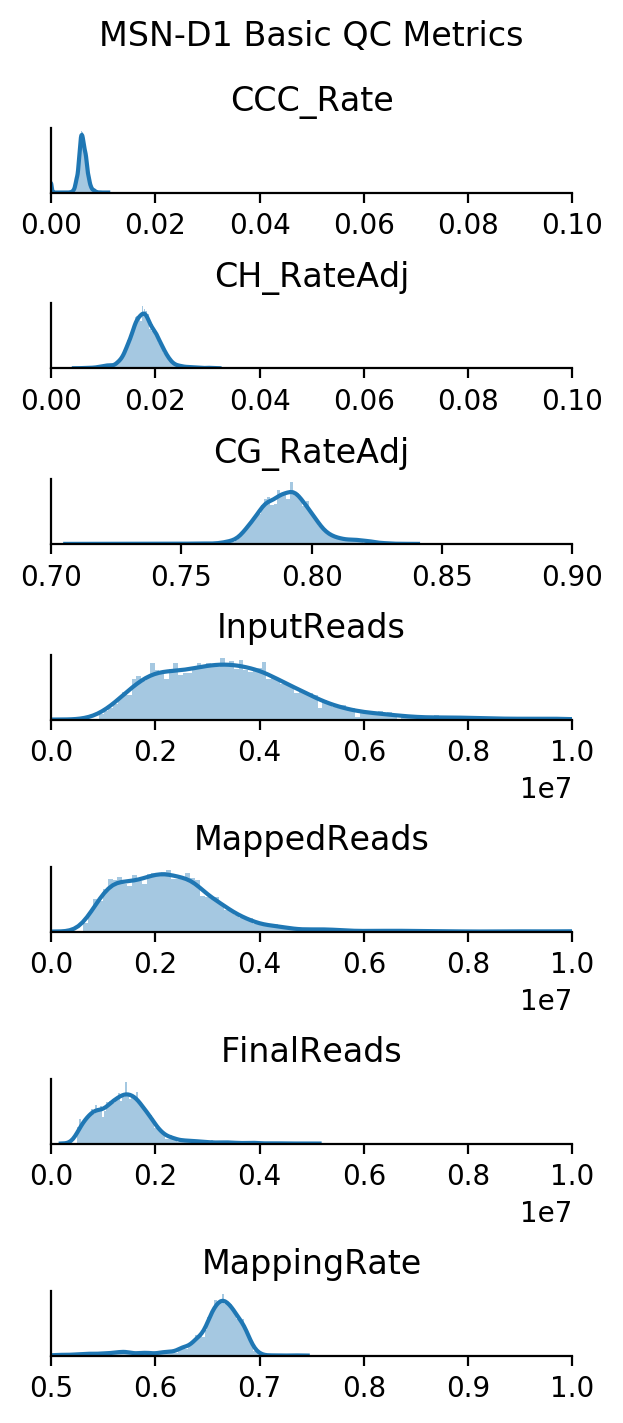

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

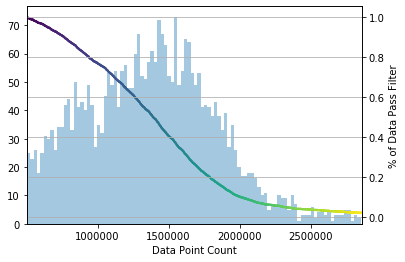

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 3139/3139 (100.0%)
CG_RateAdj passed 3139/3139 (100.0%)
CH_RateAdj passed 3139/3139 (100.0%)
FinalReads passed 3139/3139 (100.0%)
MappingRate passed 3139/3139 (100.0%)
Overall passed 3139/3139 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171214 416
171219 554
180109 177
180110 161
180111 64
180119 4
180205 1
180220 19
180222 13
180312 1
180320 23
180329 4
180402 3
180405 183
180416 1
180419 1
180806 2
180911 5
180917 7
180925 582
181002 1
181015 51
181016 63
181022 1
181204 12
181206 489
181210 2
181218 116
181220 181
190122 1
190207 1


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 373 97.1%
ad002 419 109.1%
ad004 379 98.7%
ad006 371 96.6%
ad007 391 101.8%
ad008 397 103.4%
ad010 379 98.7%
ad012 430 112.0%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
1B_M_164,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.007350,0.806380,0.804950,0.024720,0.017500,562589.0,1375354,737153.0,1B,...,17.392956,-0.502110,-1.262607,39.450214,MSN-D1,-3.496139,-19.085440,38.584865,-12.026492,True
1B_M_198,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.006120,0.809840,0.808670,0.020890,0.014860,1384595.0,2958342,1990319.0,1B,...,17.220243,-0.294812,-1.918130,38.802952,MSN-D1,-3.854568,-18.733025,37.601127,-12.349961,True
1B_M_265,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.005320,0.790880,0.789760,0.019520,0.014280,1663023.0,3705424,2444983.0,1B,...,18.900183,-1.092294,4.730732,39.220387,MSN-D1,-3.905623,-20.747101,49.850935,-12.743611,True
1B_M_349,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.007190,0.785320,0.783770,0.025800,0.018740,851236.0,1887368,1137531.0,1B,...,18.526625,-2.161125,3.173435,41.225324,MSN-D1,-1.844224,-20.950796,51.968421,0.938860,True
2E_M_1,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.006030,0.819930,0.818840,0.024240,0.018320,672804.0,1611826,984930.0,2E,...,16.395260,-0.827119,-1.317242,37.742320,MSN-D1,-3.843009,-17.650747,33.744172,-13.534998,True
2E_M_110,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.005070,0.819090,0.818170,0.017490,0.012480,3119669.0,8446050,5133759.0,2E,...,16.116648,0.018880,-4.511177,36.843081,MSN-D1,-3.134205,-17.612692,34.751265,-11.682431,True
2E_M_1224,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.004920,0.818190,0.817290,0.019690,0.014840,824753.0,2340050,1342468.0,2E,...,16.137085,-0.618404,-1.862758,37.465655,MSN-D1,-3.600902,-17.594656,33.998149,-12.667825,True
2E_M_1232,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.004740,0.825990,0.825160,0.018350,0.013670,1163656.0,3116646,1907452.0,2E,...,16.222721,-0.764514,-1.702214,37.210281,MSN-D1,-3.820975,-17.545820,33.905033,-12.754110,True
2E_M_1246,/gale/raidix/rdx-4/CEMBA_RS1/2E/CEMBA180220_2E...,0.004920,0.822540,0.821660,0.018660,0.013810,1263195.0,3282222,2041155.0,2E,...,16.207190,-0.241553,-2.968294,37.028840,MSN-D1,-3.529080,-17.413904,32.952103,-10.413403,True
